# pix2pix | EPOCH Laboratory 2021

Image translation using conditional GAN's. Using this technique we can colorize black and white photos, convert google maps to google earth or in this instance predict terrain erosion.

- Python: 3.7.6
- Tensorflow: 2.2.0

In [1]:
import os, time, datetime

import tensorflow as tf

from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Concatenate, BatchNormalization, Dropout, LeakyReLU, ReLU, ZeroPadding2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
from IPython import display

In [2]:
print("Version:", tf.__version__)
print("Eager mode:", tf.executing_eagerly())
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Version: 2.1.0
Eager mode: True
GPU is available


## Explore the data

In [3]:
JOB = '/mnt/igloo/projects/loco/toolkit/pix2pix'
DATA = JOB + '/work/data/erosion'
OUTDIR = JOB + '/work/code/training_loop'

In [4]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_png(image)

    w = tf.shape(image)[1]
    w = w // 2
    input_image = image[:, :w, :]
    result_image = image[:, w:, :]

    input_image = tf.cast(input_image, tf.float32)
    result_image = tf.cast(result_image, tf.float32)

    return input_image, result_image

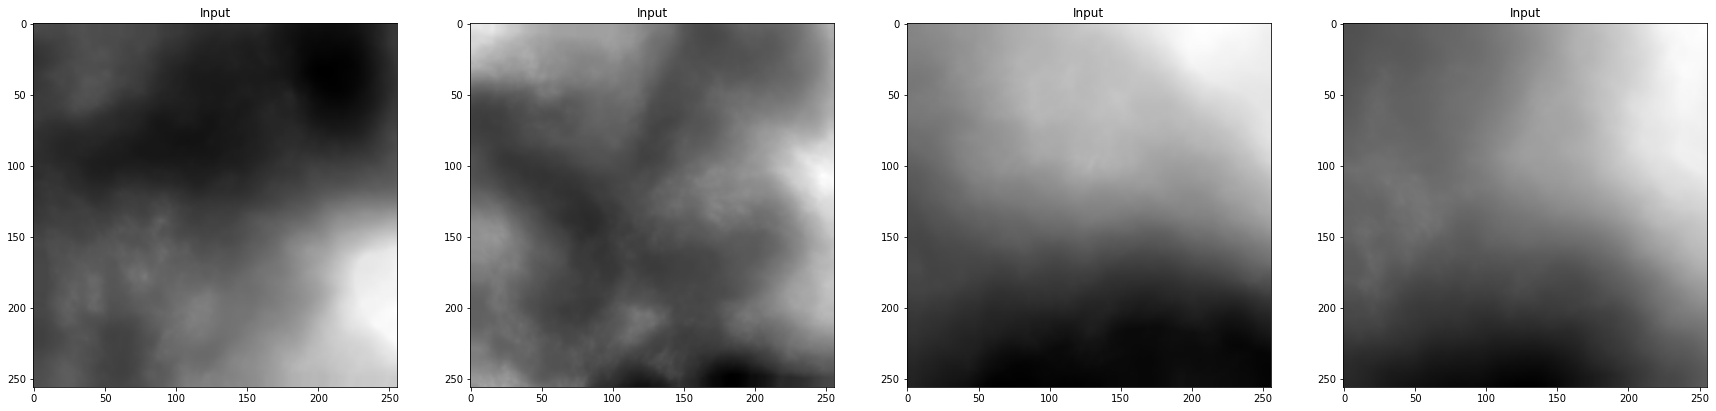

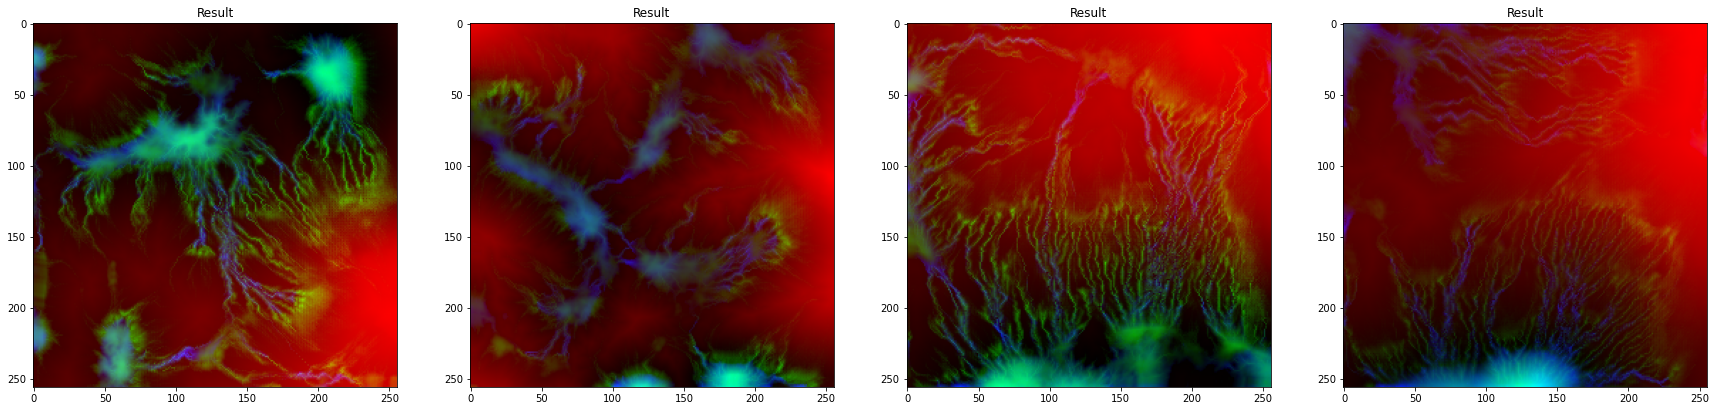

In [5]:
nplot = 4

for i in range(2):
    fig = plt.figure(figsize=(30,10))
    title = ['Input', 'Result']
    
    for count in range(1,nplot+1):
        inp, re = load(DATA + '/train/' + str(count) + '.png')
        display_list = [inp, re]
        ax = fig.add_subplot(1,nplot,count)
        plt.title(title[i])
        ax.imshow(display_list[i]/255.0)
        
    plt.show()

## Create the GAN

In [6]:
# Custom variables (Defaults: fsize = 4 | numgenlayers = 16)
fsize = 6
numgenlayers = 16

OUTPUT_CHANNELS = 3

#### The Generator

In [7]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = Sequential()
    result.add(Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(BatchNormalization())

    result.add(LeakyReLU())

    return result

In [8]:
# Define downscaling model
down_model = downsample(3, fsize)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


In [9]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = Sequential()
    result.add(Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    result.add(BatchNormalization())

    if apply_dropout:
        result.add(Dropout(0.5))

    result.add(ReLU())

    return result

In [10]:
# Define upscaling model
up_model = upsample(3, fsize)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [11]:
def build_generator():
    inputs = Input(shape=[256,256,3])

    down_stack = [
        downsample(64, fsize, apply_batchnorm=False), # (bs, 128, 128, 64)
        downsample(128, fsize), # (bs, 64, 64, 128)
        downsample(256, fsize), # (bs, 32, 32, 256)
        downsample(512, fsize), # (bs, 16, 16, 512)
        downsample(512, fsize), # (bs, 8, 8, 512)
        downsample(512, fsize), # (bs, 4, 4, 512)
        downsample(512, fsize), # (bs, 2, 2, 512)
        downsample(512, fsize), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, fsize, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, fsize, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, fsize, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, fsize), # (bs, 16, 16, 1024)
        upsample(256, fsize), # (bs, 32, 32, 512)
        upsample(128, fsize), # (bs, 64, 64, 256)
        upsample(64, fsize), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = Concatenate()([x, skip])

    x = last(x)

    return Model(inputs=inputs, outputs=x)

In [12]:
generator = build_generator()
#generator.summary()
tf.keras.utils.plot_model(generator, to_file=OUTDIR + '/genmodel_workflow.png', show_shapes=True, dpi=64)
plt.close()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 128, 128, 64) 6912        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 64, 64, 128)  295424      sequential_2[0][0]               
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 32, 32, 256)  1180672     sequential_3[0][0]               
______________________________________________________________________________________________

#### The Discriminator

In [15]:
def build_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = Input(shape=[256, 256, 3], name='input_image')
    tar = Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

    down1 = downsample(64, fsize, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, fsize)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, fsize)(down2) # (bs, 32, 32, 256)

    disc = ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    disc = Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(disc) # (bs, 31, 31, 512)
    disc = BatchNormalization()(disc)
    disc = LeakyReLU()(disc)
    disc = ZeroPadding2D()(disc) # (bs, 33, 33, 512)
    output = Conv2D(1, 4, strides=1, kernel_initializer=initializer)(disc) # (bs, 30, 30, 1)

    return Model(inputs=[inp, tar], outputs=output)

In [16]:
discriminator = build_discriminator()
#print(discriminator.summary())
tf.keras.utils.plot_model(discriminator, to_file=OUTDIR + '/discrimmodel_workflow.png', show_shapes=True, dpi=64)
plt.close()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
target_image (InputLayer)       [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_image[0][0]                
                                                                 target_image[0][0]               
__________________________________________________________________________________________________
sequential_17 (Sequential)      (None, 128, 128, 64) 13824       concatenate_7[0][0]        

## Build datasets

In [20]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

#### Augmentation functions

In [21]:
def resize(input_image, result_image, height, width):
    input_image = tf.image.resize(input_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    result_image = tf.image.resize(result_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, result_image

In [22]:
def random_crop(input_image, result_image):
    stacked_image = tf.stack([input_image, result_image], axis=0)
    cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

In [23]:
@tf.function()
def random_jitter(input_image, result_image):
    # resizing to 286 x 286 x 3
    input_image, result_image = resize(input_image, result_image, 286, 286)

    # randomly cropping to 256 x 256 x 3
    input_image, result_image = random_crop(input_image, result_image)

    if tf.random.uniform(()) > 0.5:
        # random mirroring
        input_image = tf.image.flip_left_right(input_image)
        result_image = tf.image.flip_left_right(result_image)

    return input_image, result_image

#### Construct datasets

In [24]:
def normalize(input_image, result_image):
    input_image = (input_image / 127.5) - 1
    result_image = (result_image / 127.5) - 1

    return input_image, result_image

In [25]:
def load_image_train(image_file):
    input_image, result_image = load(image_file)
    input_image, result_image = random_jitter(input_image, result_image)
    input_image, result_image = normalize(input_image, result_image)

    return input_image, result_image

In [26]:
def load_image_test(image_file):
    input_image, result_image = load(image_file)
    input_image, result_image = resize(input_image, result_image,IMG_HEIGHT, IMG_WIDTH)
    input_image, result_image = normalize(input_image, result_image)

    return input_image, result_image

In [27]:
# Load training dataset
train_dataset = tf.data.Dataset.list_files(DATA + '/train/*.png')
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [28]:
# Load testing dataset
test_dataset = tf.data.Dataset.list_files(DATA + '/test/*.png')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Training the network

In [29]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

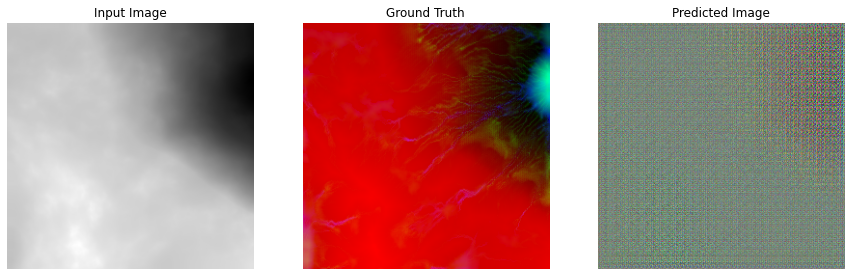

In [30]:
# Test of prediction vizualization
for example_input, example_target in test_dataset.take(1):
    generate_images(generator, example_input, example_target)

#### Loss functions

In [13]:
LAMBDA = 100

In [17]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [19]:
generator_optimizer = Adam(2e-4, beta_1=0.5)
discriminator_optimizer = Adam(2e-4, beta_1=0.5)

In [14]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))     # mean absolute error
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

In [18]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

#### Checkpoints

In [31]:
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
print("ID:", timestamp)

ID: 20201212-005147


In [32]:
log_dir = OUTDIR + "/logs"
summary_writer = tf.summary.create_file_writer(log_dir + "/fit/" + timestamp)

In [33]:
checkpoint_dir = OUTDIR + '/training_checkpoints/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

#### Restore checkpoint (Optional)

In [34]:
# Restore the latest checkpoint in checkpoint_dir
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

#### Training loop

In [35]:
command = "tensorboard --logdir=" + str(log_dir) + " --port=6006 &"
os.system(command)

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [36]:
EPOCHS = 200
loss_min = 9999999

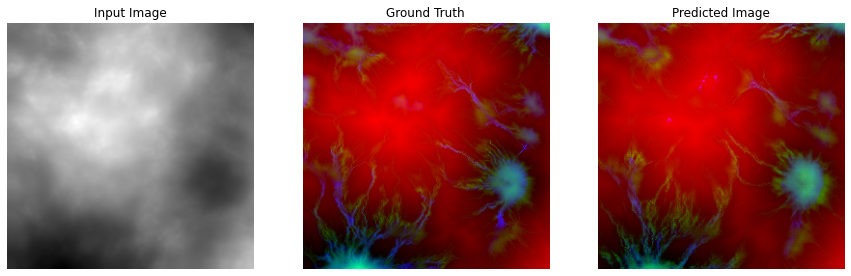

Epoch:  199
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
d_loss: 1.24316227
gen_total_loss: 5.30221224
gen_gan_loss: 1.26959622
gen_l1_loss: 0.0403261632
Time taken for epoch 200 is 128.11167645454407 sec



In [37]:
for epoch in range(EPOCHS):
    
    start = time.time()
    display.clear_output(wait=True)
    
    for example_input, example_target in test_dataset.take(1):
        generate_images(generator, example_input, example_target)

    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_dataset.enumerate():
        print('.', end='')
        if (n+1) % 100 == 0:
            print()
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            #Forward pass
            gen_output = generator(input_image, training=True)
            disc_real_output = discriminator([input_image, target], training=True)
            disc_generated_output = discriminator([input_image, gen_output], training=True)
            
            #Compute losses
            gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
            disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

        #Compute gradients
        generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        # Update Weights
        generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

        with summary_writer.as_default():
            tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
            tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
            tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
            tf.summary.scalar('disc_loss', disc_loss, step=epoch)
    
    print('d_loss:', end=' '), tf.print(disc_loss)
    print('gen_total_loss:', end=' '), tf.print(gen_total_loss)
    print('gen_gan_loss:', end=' '), tf.print(gen_gan_loss)
    print('gen_l1_loss:', end=' '), tf.print(gen_l1_loss)

    if gen_total_loss < loss_min:
        generator.save(OUTDIR + "/results/generator_" + timestamp + '.h5')
        print("Model saved")
        loss_min = gen_total_loss

    if (epoch + 1) % 20 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))

## Inference

In [38]:
generator = build_generator()
generator.load_weights(OUTDIR + "/results/generator_" + timestamp + ".h5")

In [39]:
val_dataset = tf.data.Dataset.list_files(DATA + '/val/*.png')
val_dataset = val_dataset.map(load_image_test)
val_dataset = val_dataset.batch(BATCH_SIZE)

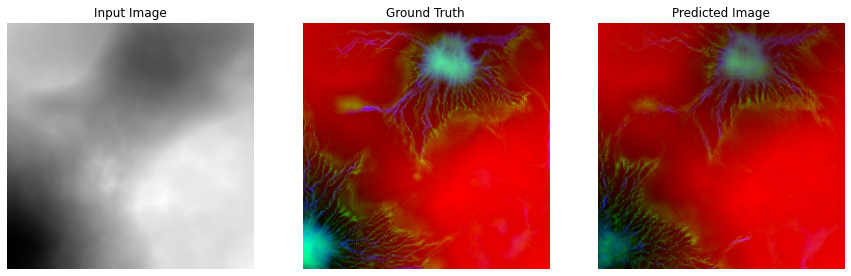

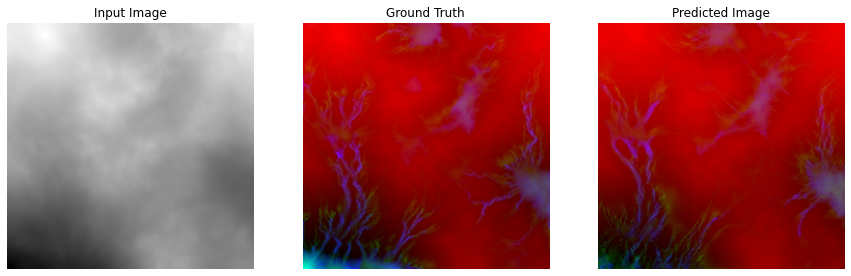

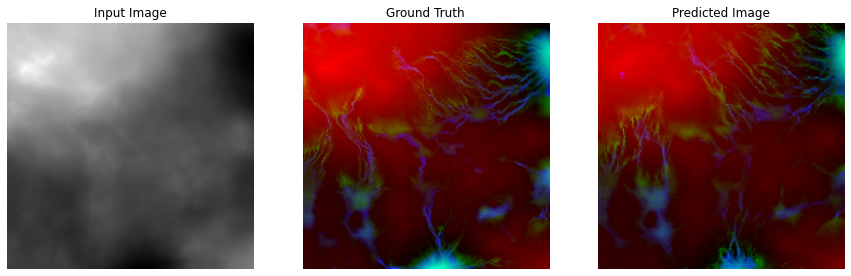

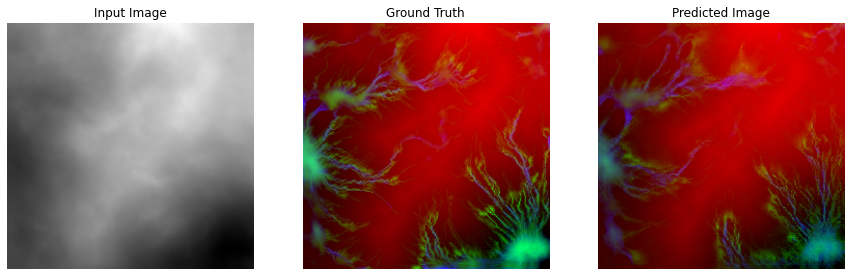

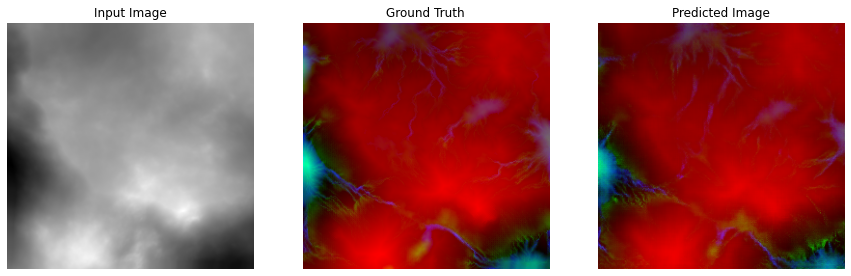

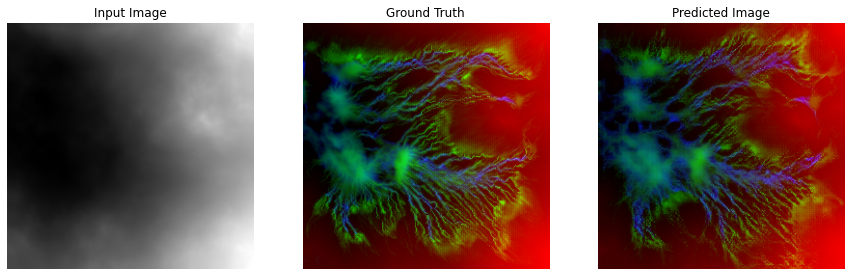

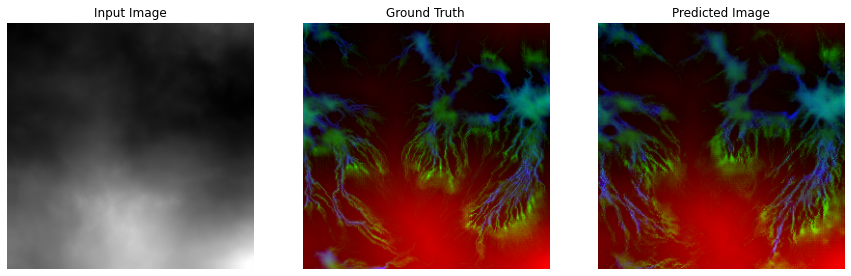

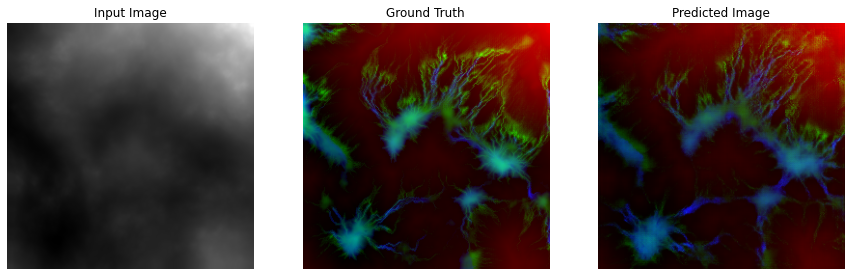

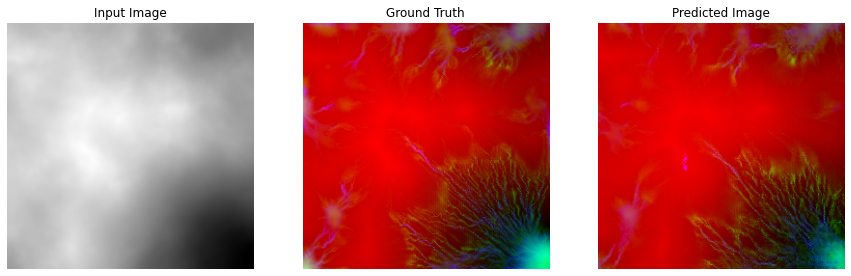

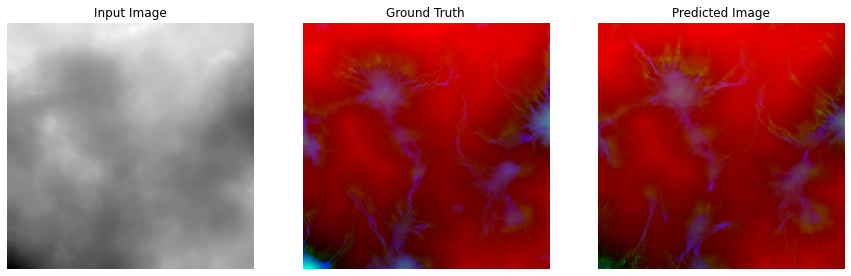

In [40]:
for count in range(5):
    for inp, tar in val_dataset.take(count):
        generate_images(generator, inp, tar)

## Validation

In [41]:
prediction = generator(inp, training=False)

In [42]:
for inp, tar in val_dataset.take(1):    
    ssim = tf.image.ssim(prediction, tar, max_val = 255)
    psnr = tf.image.psnr(prediction, tar, max_val = 255)
    
    print('SSIM:', end=' '), tf.print(ssim)
    print('PSNR:', end=' '), tf.print(psnr)

SSIM: [0.975757182]
PSNR: [55.1101723]
